In [4]:
import math
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.stats import norm

# First Version

Option parameters

In [2]:
S = 100 # underlying price 
K = 100 # strike price
r = 0.05 # risk-free rate 
q = 0.02 # dividend yield 
T = 0.5 # time to maturity 
sigma = 0.2 # volatility

Black-Scholes-Merton formula for vanilla call option price

In [4]:
d1 = (math.log(S/K) + (r - q + sigma**2/2)*T) / (sigma*math.sqrt(T)) 
d2 = d1 - sigma*math.sqrt(T)
N_d1 = 0.5 + 0.5*math.erf(d1/math.sqrt(2))
N_d2 = 0.5 + 0.5*math.erf(d2/math.sqrt(2))
C = S*math.exp(-q*T)*N_d1 - K*math.exp(-r*T)*N_d2

Option Greeks

In [5]:
delta = math.exp(-q*T) * N_d1
gamma = math.exp(-q*T) * math.exp(-d1**2/2) / (S*sigma*math.sqrt(2*math.pi*T))
speed = -gamma*d1/(S*sigma*math.sqrt(T))
vega = S*math.exp(-q*T)*math.exp(-d1**2/2)*math.sqrt(T)/(100*100)
vomma = vega*d1*d2/sigma
charm = -math.exp(-q*T) * (N_d1*d2*math.exp(-d1**2/2))/(2*T*sigma*math.sqrt(T))
vanna = -math.exp(-q*T) * N_d1 * d2 / sigma
color = -math.exp(-q*T) * math.exp(-d1**2/2) * (d2/(sigma*math.sqrt(T))) * (1-d1*d2/(sigma*math.sqrt(T)))

Visualize Option Greeks

In [6]:
greeks = [delta, gamma, speed, vega, vomma, charm, vanna, color]
greeks_labels = ['Delta', 'Gamma', 'Speed', 'Vega', 'Vomma', 'Charm', 'Vanna', 'Color']

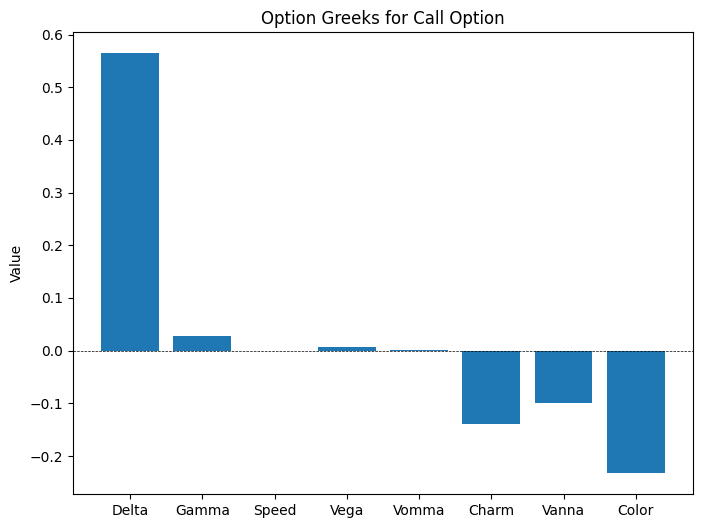

In [7]:
fig, ax = plt.subplots(figsize=(8, 6)) 
ax.bar(greeks_labels, greeks) 
ax.set_title('Option Greeks for Call Option') 
ax.set_ylabel('Value')
ax.axhline(y=0, color='black', linestyle='--', linewidth=0.5) 
plt.show()

# Second Version

https://quant-next.com/option-greeks-and-pl-decomposition-part-1/

In [11]:
#Black-Scholes price and Greeks
class EuropeanOptionBS:

    def __init__(self, S, K, T, r, q, sigma, Type):
        self.S = S
        self.K = K
        self.T = T
        self.r = r
        self.q = q        
        self.sigma = sigma
        self.Type = Type
        self.d1 = self.d1()
        self.d2 = self.d2()
        self.price = self.price()
        self.delta = self.delta()
        self.theta = self.theta()
        self.vega = self.vega()
        self.gamma = self.gamma()
        self.volga = self.volga()
        self.vanna = self.vanna()        
        
    def d1(self):
        d1 = (math.log(self.S / self.K) \
                   + (self.r - self.q + .5 * (self.sigma ** 2)) * self.T) \
                    / (self.sigma * self.T ** .5)       
        return d1

    def d2(self):
        d2 = self.d1 - self.sigma * self.T ** .5     
        return d2
    
    def price(self):
        if self.Type == "Call":
            price = self.S * math.exp(-self.q * self.T) * norm.cdf(self.d1) \
            - self.K * math.exp(-self.r * self.T) * norm.cdf(self.d2)
        if self.Type == "Put":
            price = self.K * math.exp(-self.r * self.T) * norm.cdf(-self.d2) \
            - self.S * math.exp(-self.q * self.T) * norm.cdf(-self.d1)            
        return price
    
    def delta(self):
        if self.Type == "Call":
            delta = math.exp(-self.q * self.T) * norm.cdf(self.d1)
        if self.Type == "Put":
            delta = -math.exp(-self.q * self.T) * norm.cdf(-self.d1)
        return delta
    
    def theta(self):
        if self.Type == "Call":
            theta1 = -math.exp(-self.q * self.T) * \
            (self.S * norm.pdf(self.d1) * self.sigma) / (2 * self.T ** .5)
            theta2 = self.q * self.S * math.exp(-self.q * self.T) * norm.cdf(self.d1)
            theta3 = -self.r * self.K * math.exp(-self.r * self.T) * norm.cdf(self.d2)
            theta = theta1 + theta2 + theta3
        if self.Type == "Put":
            theta1 = -math.exp(-self.q * self.T) * \
            (self.S * norm.pdf(self.d1) * self.sigma) / (2 * self.T ** .5)
            theta2 = -self.q * self.S * math.exp(-self.q * self.T) * norm.cdf(-self.d1)
            theta3 = self.r * self.K * math.exp(-self.r * self.T) * norm.cdf(-self.d2)
            theta =  theta1 + theta2 + theta3
        return theta
    
    def vega(self):
        vega = self.S * math.exp(-self.q * self.T) * self.T** .5 * norm.pdf(self.d1)
        return vega
    
    def gamma(self):
        gamma = math.exp(-self.q * self.T) * norm.pdf(self.d1) / (self.S * self.sigma * self.T** .5)
        return gamma
    
    def volga(self):
        volga = self.vega / self.sigma * self.d1 * self.d2
        return volga
    
    def vanna(self):
        vanna = -self.vega / (self.S * self.sigma * self.T** .5) * self.d2
        return vanna

In [12]:
#parameters
S0 = 100 # stock price
K = 95 # strike price
r = .0 # risk-free interest rate
q = .0 # dividend
T0 = .25 # time to maturity
sigma0 = .4 # implied volatility BS
Type = "Put"
dt = 1 / 252 # 1 business day

In [13]:
# Market changes between t and t + dt
dS = -S0 * sigma0 * dt**.5 # dS^2 / S^2 = sigma0^2 * dt
dsigma = .0
T1 = T0 - dt
S1 = S0 + dS
sigma1 = sigma0 + dsigma

In [14]:
P0 = EuropeanOptionBS(S0, K, T0, r, q, sigma0, Type).price
P1 = EuropeanOptionBS(S1, K, T1, r, q, sigma1, Type).price
delta0 = EuropeanOptionBS(S0, K, T0, r, q, sigma0, Type).delta
isDeltaHedged = 1 #1 if is delta-hedged, 0 otherwise
dPandL = P1 - P0 - delta0 * dS * isDeltaHedged
print("P&L: " + str(dPandL))

P&L: 0.00039375586755807657


In [15]:
#initial greeks
theta0 = EuropeanOptionBS(S0, K, T0, r, q, sigma0, Type).theta
vega0 = EuropeanOptionBS(S0, K, T0, r, q, sigma0, Type).vega
gamma0 = EuropeanOptionBS(S0, K, T0, r, q, sigma0, Type).gamma
volga0 = EuropeanOptionBS(S0, K, T0, r, q, sigma0, Type).volga
vanna0 = EuropeanOptionBS(S0, K, T0, r, q, sigma0, Type).vanna

In [16]:
#P&L attribution
delta_PandL = delta0 * dS * (1 - isDeltaHedged)
theta_PandL = theta0 * dt
vega_PandL = vega0 * dsigma
gamma_PandL = 1 / 2 * gamma0 * dS**2
volga_PandL = 1 / 2 * volga0 * dsigma**2
vanna_PandL = vanna0 * dS * dsigma
unexplained = dPandL - sum([delta_PandL, theta_PandL, vega_PandL, gamma_PandL, volga_PandL, vanna_PandL])

In [17]:
y = [delta_PandL, theta_PandL, vega_PandL, gamma_PandL, volga_PandL, vanna_PandL, unexplained]
x = ["delta", "theta", "vega", "gamma", "volga", "vanna","unexplained"]


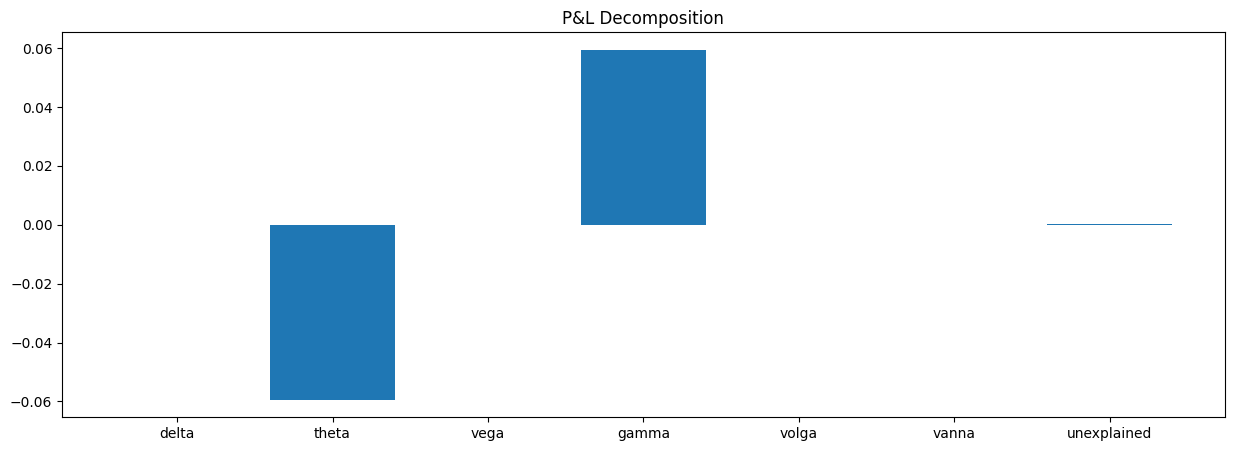

In [18]:
fig = plt.figure(figsize=(15, 5))
plt.bar(x, y)
plt.title("P&L Decomposition")
plt.show();